# CS146 - Assignment 4
## Jasen Lo

### Posterior predictive tests. 
Refer back to the medical trial pre-class work notebook from
Session 8.1. The notebook contains a non-hierarchical model (first) and a hierarchical
model (second).
For the non-hierarchical model and the control group half of the data set, choose a test
statistic to show that the non-hierarchical model does not explain the control group data
well. You should generate posterior data samples from this model and compare the test
statistic of the real data to the distribution under your samples from the posterior. Note that
the posterior distribution for this model is already provided in the notebook, so you don’t
have to calculate it.
Submit your test statistic function, your code for generating samples from the posterior and
computing the test statistic, and a histogram analogous to Gelman Figure 6.4 (reproduced
below). Also, calculate and provide your p-value. Since the test statistic is supposed to
show a deficiency of the model the p-value should be less than 0.05 or greater than 0.95.


We consider the eczema medical trial data set again. This time we will compare which of 2 models explain the observed data best.

* Model 1: All studies have the same probability of success.


|Study          | Treatment group |   Control group  |
|---------------|-----------------|------------------|
|Di Rienzo 2014 |     20 / 23     |        9 / 15    |
|Galli 1994     |     10 / 16     |       11 / 18    |
|Kaufman 1974   |     13 / 16     |        4 / 10    |
|Qin 2014       |     35 / 45     |       21 / 39    |
|Sanchez 2012   |     22 / 31     |       12 / 29    |
|Silny 2006     |      7 / 10     |        0 / 10    |
|**Totals**     |    107 / 141    |       57 / 121   |


**Model 1:**

* For each group (treatment and control), all 6 studies have the same fixed, but unknown, probability of success, $\theta_t,\theta_c\in[0,1]$.
* The data follow a binomial distribution in each study, conditioned on the probability of success — $\theta_t$ for treatment or $\theta_c$ for control.
* The priors over $\theta_t$ and $\theta_c$ are uniform.

These assumptions lead to the following model.

* Likelihood: $\prod_{i=1}^6 \text{Binomial}(s_i\,|\,\theta, n_i)$, where $s_i$ is the number of successful recoveries, $f_i$ is the number of failures (did not recover), and $n_i=s_i+f_i$ the number of patients.

* Prior: $\text{Beta}(\theta\,|\,1,1)$ for both $\theta_t$ and $\theta_c$.

* Posterior for treatment group: $\text{Beta}(\theta_t\,|\,108, 35)$.

* Posterior for control group: $\text{Beta}(\theta_c\,|\,58, 65)$.

In [161]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

#control successes
control_sucess_data = [9,11,4,21,12,0]

#control count
control_total_data = [15,18,10,39,29,10]

In [162]:
#test statistic of the standard deviation of the success rates of the six trials for the control data.
#I choose the standard deviation to be the test statistic because looking at the control group data, there seems
#to be a large variety of sucess rates ranging from 0% to 60%. By assuming each of the trials has a fixed probability
#sucess (theta), my intuition is that the model will most likely under estimate the deviation of rates of success
#in each trial. The model will fails if most of the standard deviations of the replicated data fall to the left (less)
#of the observed data standard deviation

def test_statistic(data):
    s_rates = []
    for i in range(len(data)):
        s_rate = data[i]/control_control_total_data[i]
        s_rates.append(s_rate)
    stdev = np.std(s_rates)
    return stdev

In [163]:
#generate 1000 posterior samples of theta
posterior_samples = sts.beta.rvs(a=58,b=65,size=1000)

#empty list for 1000 lists of replicated data
rep_data_list = []

#for loop goes through each sample theta
for i in posterior_samples:
    
    #empty list of sucessful cases in each of the 6 trial for sample theta
    likelihoods =[]
    
    #for loop goes through the 6 likelihood functions
    for j in control_c:
        
        #generates a sample number of successful cases in each trial
        s = int(sts.binom.rvs(n = j, p = i, size = 1))
        
    #appends to inner and outer lists
        likelihoods.append(s)
    rep_data_list.append(likelihoods)
    
#sanity check.
print(rep_data_list[:3])

[[6, 7, 5, 22, 16, 5], [8, 9, 8, 17, 13, 5], [7, 9, 3, 18, 14, 5]]


In [164]:
#Creates list of 1000 test statistics 
#for the 1000 replicated data sets
rep_test_stat = []
for i in rep_data_list:
    rep_test_stat.append(test_stat(i))

#Test statistic for observed data 
true_test_stat = test_stat(control_sucess_data)

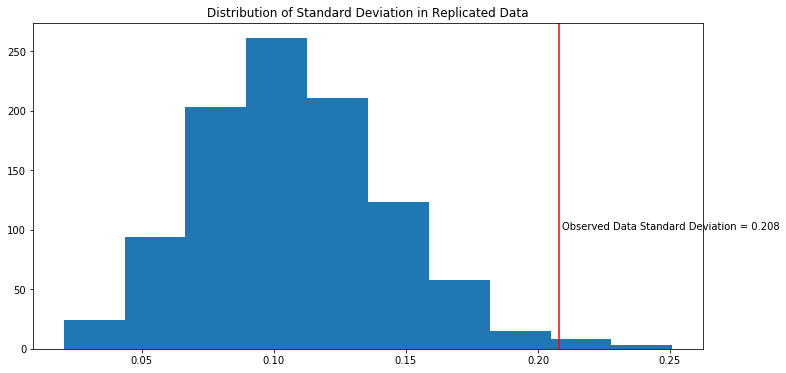

p_value =  0.009
Observed Data Standard Deviation 0.20795900518575364
Average of the Replicated Data Standard Deviations 0.10767114414619906


In [165]:
#histogram analogous to Gelman Figure 6.4
plt.figure(figsize=(12, 6))
plt.hist(rep_test_stat)
plt.axvline(true_test_stat, color = 'r')
plt.text(true_test_stat+0.001,100,'Observed Data Standard Deviation = 0.208')
plt.title("Distribution of Standard Deviation in Replicated Data")
plt.show()

#Also, calculate and provide your p-value. Since the test statistic is supposed to
#show a deficiency of the model the p-value should be less than 0.05 or greater than 0.95.
outlier = 0
for i in rep_test_stat:
    if i > true_test_stat:
        outlier += 1
p_value = outlier/len(rep_test_stat)
print("p_value = ", p_value)
print("Observed Data Standard Deviation", true_test_stat)
print("Average of the Replicated Data Standard Deviations", np.mean(rep_test_stat))

### 2. Posterior predictive tests. 
Again, refer back to the medical trial pre-class work notebook from Session 8.1. Generate samples from the posterior data distribution of the hierarchical model and evaluate the same test statistic(s) for the control group as you did for the non-hierarchical model in the required exercise above. What are the histograms and
p-values in the hierarchical case? Can you create a new test statistic that points out a
deficiency of the hierarchical model on the control group data?

In [166]:
import pystan

In [176]:
# For Stan we provide all known quantities as data, namely the observed data
# and our prior hyperparameters.
stan_data = {
    'control': {
        'alpha': 1,
        'beta': 1,
        'num_trials': 6,
        'patients': [15, 18, 10, 39, 29, 10],
        'improved': [9, 11, 4, 21, 12, 0]}}

In [177]:
# Below is the Stan code for the medical trial data set. Note that the Stan
# code is a string that is passed to the StanModel object below.

# We have to tell Stan what data to expect, what our parameters are and what
# the likelihood and prior are. Since the posterior is just proportional to
# the product of the likelihood and the prior, we don't distinguish between
# them explicitly in the model below. Every distribution we specify is
# automatically incorporated into the product of likelihood * prior.

stan_code = """

// The data block contains all known quantities - typically the observed
// data and any constant hyperparameters.
data {  
    int<lower=1> num_trials;  // number of trials in the data set
    int<lower=0> patients[num_trials];  // number of patients per trial
    int<lower=0> improved[num_trials];  // number of improved patients per trial
    real<lower=0> alpha;  // fixed prior hyperparameter
    real<lower=0> beta;   // fixed prior hyperparameter
}

// The parameters block contains all unknown quantities - typically the
// parameters of the model. Stan will generate samples from the posterior
// distributions over all parameters.
parameters {
    real<lower=0,upper=1> p;  // probability of improvement - the
                              // parameter of the binomial likelihood
}

// The model block contains all probability distributions in the model.
// Think of this as specifying the generative model for the scenario.
model {
    p ~ beta(alpha, beta);  // prior over p
    for(i in 1:num_trials) {
        improved[i] ~ binomial(patients[i], p);  // likelihood function
    }
}

"""

In [143]:
# This cell takes a while to run. Compiling a Stan model will feel slow even
# on simple models, but it isn't much slower for really complex models. Stan
# is translating the model specified above to C++ code and compiling the C++
# code to a binary that it can executed. The advantage is that the model needs
# to be compiled only once. Once that is done, the same code can be reused
# to generate samples for different data sets really quickly.

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb314c3a111e1df367a935c155d82062 NOW.


In [178]:
# Fit the model to the data. This will generate samples from the posterior over
# all parameters of the model. We start by computing posteriors for the treatment
# data.

stan_results_control = stan_model.sampling(data=stan_data['control'])
posterior_samples_control = stan_results_control.extract()
posterior_samples_2 = posterior_samples_control['p']

#empty list for 1000 lists of replicated data
rep_data_list = []

#for loop goes through each sample theta
for i in posterior_samples_2:
    
    #empty list of sucessful cases in each of the 6 trial for sample theta
    likelihoods =[]
    
    #for loop goes through the 6 likelihood functions
    for j in control_c:
        
        #generates a sample number of successful cases in each trial
        s = int(sts.binom.rvs(n = j, p = i, size = 1))
        
    #appends to inner and outer lists
        likelihoods.append(s)
    rep_data_list.append(likelihoods)
    
#sanity check.
print(rep_data_list[:3])

[[9, 12, 5, 25, 14, 5], [9, 7, 4, 20, 7, 5], [9, 11, 6, 18, 10, 4]]


In [179]:
#Creates list of 1000 test statistics 
#for the 1000 replicated data sets
rep_test_stat = []
for i in rep_data_list:
    rep_test_stat.append(test_stat(i))


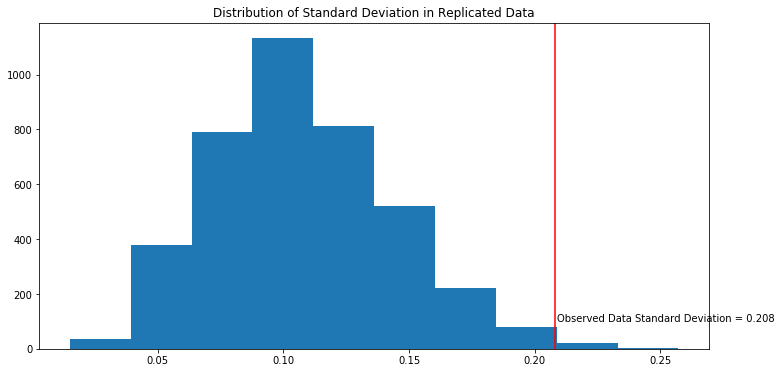

p_value =  0.00625
Observed Data Standard Deviation 0.20795900518575364
Average of the Replicated Data Standard Deviations 0.10756264353340345


In [180]:
#Surprised to find that the hierarchical model also models the standard deviation of the successes of the 
#control data poorly, worst than the first model, with an even lower p-value of 0.00625

#histogram analogous to Gelman Figure 6.4
plt.figure(figsize=(12, 6))
plt.hist(rep_test_stat)
plt.axvline(true_test_stat, color = 'r')
plt.text(true_test_stat+0.001,100,'Observed Data Standard Deviation = 0.208')
plt.title("Distribution of Standard Deviation in Replicated Data")
plt.show()

#Also, calculate and provide your p-value. Since the test statistic is supposed to
#show a deficiency of the model the p-value should be less than 0.05 or greater than 0.95.
outlier = 0
for i in rep_test_stat:
    if i > true_test_stat:
        outlier += 1
p_value = outlier/len(rep_test_stat)
print("p_value = ", p_value)
print("Observed Data Standard Deviation", true_test_stat)
print("Average of the Replicated Data Standard Deviations", np.mean(rep_test_stat))